In [48]:
import torch
import numpy as np
from tqdm.auto import tqdm
from model import BendrEncoder
import os
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from src.data.processing import load_data_dict, get_data
from src.data.conf.eeg_channel_picks import hackathon
from src.data.conf.eeg_channel_order import standard_19_channel
from src.data.conf.eeg_annotations import braincapture_annotations, tuh_eeg_artefact_annotations
from torch import nn
from model.model import Flatten

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = BendrEncoder()
encoder.load_state_dict(deepcopy(torch.load("encoder.pt")))
encoder = encoder.to(device)

In [50]:
BC_path = "/mnt/c/Users/anders/Downloads/Bhutan/"
TUAR_path = "/mnt/c/Users/anders/Downloads/hackathon 01/TUAR/01_tcp_ar/"

annotations = braincapture_annotations

In [51]:
# Check if X_data and y_data are already saved
# If not, load the data and save it
if not os.path.exists("X_data.pt") or not os.path.exists("y_data.pt"):
    data_dict = load_data_dict(BC_path, annotations, labels=True)
    all_subjects = list(data_dict.keys())
    X_data, y_data = get_data(data_dict, all_subjects)
    torch.save(X_data, "X_data.pt")
    torch.save(y_data, "y_data.pt")
else:
    X_data = torch.load("X_data.pt")
    y_data = torch.load("y_data.pt")
    
X_data = X_data.to(device)
y_data = y_data.to(device)

In [52]:
latent = np.empty((X_data.shape[0], 1536, 4))
batch_size = 4

for i in tqdm(range(0, X_data.shape[0], batch_size)):
    latent[i:i+batch_size] = encoder(X_data[i:i+batch_size]).cpu().detach().numpy()
latent = latent.reshape((latent.shape[0], -1))

  0%|          | 0/144 [00:00<?, ?it/s]

/tmp/ipykernel_17910/602645801.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = ListedColormap(plt.cm.get_cmap('tab10').colors[:n_unique_labels])


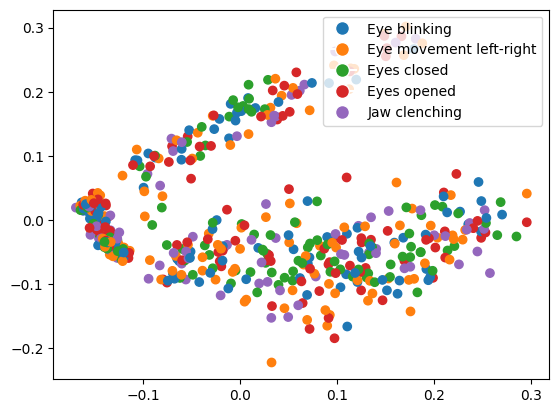

In [53]:
# Run PCA on latent
pca = PCA(n_components=30)
latent_pca = pca.fit_transform(latent)

fig, ax = plt.subplots()

# Generate a colormap that has as many colors as you have unique labels
unique_labels = torch.unique(y_data.cpu())
n_unique_labels = len(unique_labels)
cmap = ListedColormap(plt.cm.get_cmap('tab10').colors[:n_unique_labels])

# Map each label to a color
label_to_color = {label.item(): cmap(i) for i, label in enumerate(unique_labels)}

# Color each point in the scatter plot according to its label
colors = [label_to_color[label.item()] for label in y_data.cpu()]
scatter = ax.scatter(latent_pca[:, 0], latent_pca[:, 1], c=colors)

# Create legend
legend_labels = [list(annotations.keys())[value] for value in unique_labels]
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=label_to_color[value.item()], markersize=10) for label, value in zip(legend_labels, unique_labels)]
plt.legend(handles=legend_elements)

plt.show()

In [54]:
out_features = 5

model = nn.Sequential(
    encoder,
    Flatten(),
    nn.Linear(in_features = 3 * 512 * 4, out_features = 512 * 4, bias=True),
    nn.Dropout(p=0.4, inplace=False),
    nn.ReLU(),
    nn.BatchNorm1d(512 * 4),
    nn.Linear(512 * 4, out_features, bias=True) 
)

model = model.to(device)
model = model.train()

# Lock encoder parameters from training
# for param in model[0].parameters():
#     param.requires_grad = False

In [55]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(X_data, y_data)

batch_size = 4
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

learning_rate = 0.0001
n_epochs = 10

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.01, momentum=0.9, nesterov=True)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=learning_rate, epochs=n_epochs, steps_per_epoch=len(train_loader), pct_start=0.1, last_epoch=-1
)

In [56]:
for epoch in range(1, n_epochs + 1):
    total = correct = 0
    pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch}, train")
    for batch in train_loader:
        if len(batch[0]) < 2: continue            
        
        optimizer.zero_grad()
                
        X, y = batch
        X, y = X.to(device), y.to(device)
        logits = model(X)        
        _, predicted = torch.max(logits.data, 1)

        total += y.size(0)
        correct += (predicted == y).sum().item()
        
        loss = criterion(logits, y)
        loss.backward()

        optimizer.step()
        scheduler.step()
        
        pbar.update(1)
        
    pbar.set_description(f"Epoch {epoch}, train accuracy: {100 * correct / total:2f}%")   

Epoch 1, train:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 2, train:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 3, train:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 4, train:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 5, train:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 6, train:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 7, train:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 8, train:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 9, train:   0%|          | 0/115 [00:00<?, ?it/s]

Epoch 10, train:   0%|          | 0/115 [00:00<?, ?it/s]

In [57]:
with torch.no_grad():
    model.eval()
    total = correct = 0
    pbar = tqdm(total=len(test_loader), desc=f"Testing...")
    for batch in test_loader:
        if len(batch[0]) < 2: continue            
        
        optimizer.zero_grad()
                
        X, y = batch
        X, y = X.to(device), y.to(device)

        logits = model(X)        
        _, predicted = torch.max(logits.data, 1)

        total += y.size(0)
        correct += (predicted == y).sum().item()
        pbar.update(1)
        
    pbar.set_description(f"Test accuracy: {100 * correct / total:2f}%")

Testing...:   0%|          | 0/29 [00:00<?, ?it/s]

In [58]:
latent = np.empty((X_data.shape[0], 1536, 4))
batch_size = 4

for i in tqdm(range(0, X_data.shape[0], batch_size)):
    latent[i:i+batch_size] = encoder(X_data[i:i+batch_size].to(device)).cpu().detach().numpy()
latent = latent.reshape((latent.shape[0], -1))

  0%|          | 0/144 [00:00<?, ?it/s]

/tmp/ipykernel_17910/4234425530.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = ListedColormap(plt.cm.get_cmap('tab10').colors[:n_unique_labels])


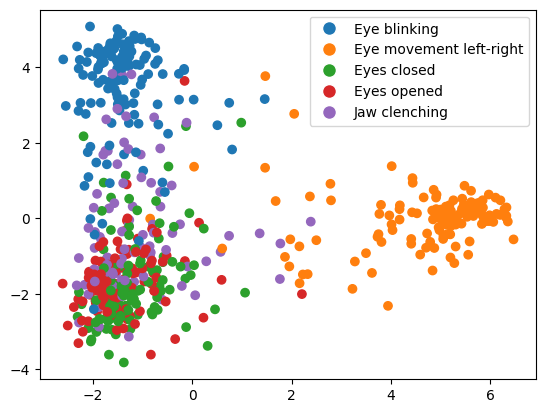

In [59]:
# Run PCA on latent
pca = PCA(n_components=30)
latent_pca = pca.fit_transform(latent)

fig, ax = plt.subplots()

# Generate a colormap that has as many colors as you have unique labels
unique_labels = torch.unique(y_data.cpu())
n_unique_labels = len(unique_labels)
cmap = ListedColormap(plt.cm.get_cmap('tab10').colors[:n_unique_labels])

# Map each label to a color
label_to_color = {label.item(): cmap(i) for i, label in enumerate(unique_labels)}

# Color each point in the scatter plot according to its label
colors = [label_to_color[label.item()] for label in y_data.cpu()]
scatter = ax.scatter(latent_pca[:, 0], latent_pca[:, 1], c=colors)

# Create legend
legend_labels = [list(annotations.keys())[value] for value in unique_labels]
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=label_to_color[value.item()], markersize=10) for label, value in zip(legend_labels, unique_labels)]
plt.legend(handles=legend_elements)

plt.show()